# Standard Operating Procedure

## Background and Rationale

<br>

**Background**

Intramolecular interactions between different parts of a protein are important for protein function. Some intramolecular interactions between different parts of the same protein can regulate protein function either positively or negatively. Amino acid residues that lie at the interface between two interacting parts of a protein are important to establish the necessary intramolecular interactions. In some cases, mutations that occur in residues at the interface between two interacting parts of a protein can lead to the deregulation of the activity of the protein and in consequence lead to disease. 

The results obtained with this pipeline were generated by mapping cancer missense mutations from the COSMIC Cancer Mutation Census database to the residues at the interface between two regions within a protein of interest. This is done to understand whether there is an enrichment of mutations at this interface in cancer. These results can help us understand the importance of the intramolecular interactions between two different parts of a protein in cancer and to determine whether these interactions are often altered in cancer. To further elucidate the importance of these intramolecular interactions in cancer, we take advantage of the annotations in the COSMIC Cancer Mutation Census. This database annotates mutations according to their cancer driver potential, and thus allows us to determine whether potential driver missense mutations are enriched at the interface residues. If the mutation of interface residues are important in the oncogenic transformation of cells we expect an enrichment of potential driver mutations at the interface residues.

**Goals of this pipeline**

This pipeline seeks to: 

1. Aid in the determination of relevant 3D protein structures that can help us determine the residues that lie at the interface between two interacting parts of a protein
2. Aid in the determination of the residues that lie at the interface between two interacting parts of a protein by analyzing 3D protein structures
3. Aid in the mapping and in the statistical enrichment analysis of cancer-associated mutations. 


**Summary of the computational approach**

Often, the residues at the interface between two interacting parts within a protein are not known in advance, especially if one has a long list of proteins and regions. For this reason, we must first determine the interface residues for the regions in the proteins provided. To do this the pipeline first determines all the Protein Data Bank (PDB) identifiers for the proteins of interest. These identifiers allow us to download the 3D structures of the proteins, which will allow us to determine the interface residues. Often, one protein will have multiple 3D structures deposited on the PDB, therefore we also determine the best structures to use for the determination of the interface residues. Once the interface residues are determined, we map the mutations from the COSMIC Cancer Mutation Census and we determine the enrichment of mutations. 

**Summary of the analyses done**

- First we perform a global mutated residue enrichment analysis that takes into account all the interface residues for all the proteins provided. This analysis allows us to determine whether in general there is a significant enrichment of mutated residues at the interface residues for all the proteins provided. If the interface residues found are important in cancer we expect a significant enrichment of residues at the interface that are hit by potential cancer driver missense mutations. 
    
- We also conduct a protein specific missense mutation enrichment analysis. Here we plot the FDR adjusted enrichment p-value for all the proteins for which we were able to determine the interface residues. As above if the intramolecular interactions mediated by the interface residues are important to understand cancer, we expect a significant enrichment of potential driver missense mutations at the interface residues. 

**Directed Acyclic Graph of the Pipeline**

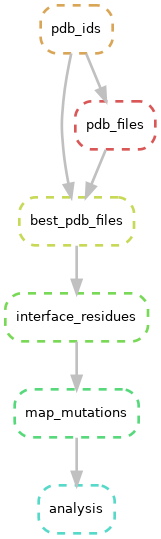

## Dependencies

We rely on widely used Python packages as well as Jupyter Lab (see below the instructions for installation):

- `snakemake`
- `pandas`
- `numpy`
- `scipy`
- `statsmodels`
- `biopython`
- `matplotlib`
- `jupyter lab`

## Operating System

Unfortunately, this pipeline can only be run successfully in MacOS or Linux because we require the full `snakemake` functionalities, which are not available for Windows. If you are using a Windows system, I recommend that you enable the Windows Subsystem for Linux following these [instructions](https://docs.microsoft.com/en-us/windows/wsl/install-win10) in order to run this pipeline. 

## Usage

### Installation

1. Install Miniconda

    - If you already have Anaconda or Miniconda installed please skip this step
    
    - Download and Install Miniconda for your operating system following these [instructions](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html)
    
2. Install the required dependencies using the `snakemake.yml` file provided

    - While in the `Pipeline` directory run the command below:
    
        `conda env create -f snakemake.yml`
        
    - This will create an environment called `snakemake` with the dependencies required to run this pipeline
    
3. If this succeeds, activate the environment with:
    
    `conda activate snakemake`
    
4. If the environment set-up failed (I am new to dealing with environments), follow these steps:

    - Make a `snakemake` environment
    
        `conda create -c conda-forge -c bioconda -n snakemake snakemake`
        
    - Activate the environment
    
        `conda activate snakemake`
        
    - Install the additional required dependencies
    
        `conda install -c conda-forge jupyterlab biopython scipy statsmodels matplotlib pandas numpy`

### Download the cancer mutation data

1. To access the COSMIC database, please register by filling out this [form](https://cancer.sanger.ac.uk/cosmic/register)

2. Download the data following this [link](https://cancer.sanger.ac.uk/cmc/download)

    You will be prompted to log-in and the download should start automatically after that
    
3. Decompress the downloaded directory, then unpack the `.tar` file 

    At this point you should have a file called `cmc_export.tsv` and a `README.txt` file
    
4. Move the `cmc_export.tsv` file to the `Pipeline/data/mutations` directory

    Please make sure that the name of the file is `cmc_export.tsv`, otherwise the pipeline will not be able to recognize the file

### How to run the pipeline

1. Make sure the `snakemake` environment is activated

    `conda activate snakemake`
    
2. While in the `Pipeline` directory, run the pipeline with this command

    `snakemake --cores 1`

### Description of the rules in the Pipeline

1. `pdb_ids`

    Given the Uniprot IDs provided in the input file for all the proteins of interest, we query the RCSB PDB REST API to obtain all the PDB IDs corresponding to all the given Uniprot IDs. We save all the PDB ids for later use. 
    
2. `pdb_files`

    We download all the mmCif files (3D structural files) corresponding to the PDB IDs determined in the previous step. These files are stored in `Pipeline/data/structures/protein_name`
   
3. `best_pdb_files`

    Given that a single protein might have multiple structures deposited in the Protein Data Bank, we determine the best structures to use. Here we parse the `.cif` structural files downloaded previously using the biopython `Bio.PDB.MMCIFParser` module. The best PDB files are those which contain more than 80% of the residues in the regions of interest for each protein in the list. We also retrieve some useful information from the protein structure files like the resolution at which the structures were determined. At this stage we can still have multiple structures per protein, the best ones will be determined in the next step. 
    
4. `interface_residues`

    Here we use the best pdb structures determined above and we determine the residues at the interface between the two regions of interest for each of the proteins provided. We use the biopython `MMCIFParser` and `NeighborSearch` modules to find the residues at the interface. We define interface residues as those residues in one region that are in a 6.5 A radius of a residue in the other region. We also determine all the possible interacting residue pairs. The structure for a given protein which contains the largest number of interface residues is selected for the next step. In the selection process we also give priority to structures that have no mutations compared to the reference sequence. At this stage we have one structure per protein. 
    
5. `map_mutations`

    Here we map the mutations from the COSMIC Cancer Mutation Census onto the interface residues of the proteins of interest. We consider only missense mutations and we consider a mutation to be a potential driver mutation if its `MUTATION_SIGNIFICANCE_TIER` is `1, 2 or 3`(see [this](https://cancer.sanger.ac.uk/cmc/help) for more information on the assignment of a significance tier). Mutations are mapped to the interface residues and to all other residues in the protein. Two analyses are possible with the data. In one we ignore the recurrence of a given mutation in the database, meaning that mutations that affect the same amino acid position are counted once. This analysis allows us to determine the enrichment of mutated residues in the interface residues. In the other analysis we take into account the recurrence of a given mutation and this allows us to determine the enrichment of missense mutations in the interface residues. 
    
    With the information available we determine the enrichment of either mutated residues or of missense mutations for each protein in the list using the binomial test under the null hypothesis that every residue in the protein has the same probability of being mutated, as described [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4609017/). We correct for multiple testing using the Benjamini/Hochberg algorithm with a false discovery rate of 0.05. 
    
6. `analysis`

    Here we create a jupyter notebook that contains the results, as well as summarized versions of the information presented in this SOP. The jupyter notebook is saved in `Pipeline/logs/notebooks`. The plots in the jupyter notebook are saved in `Pipeline/figures`.
    
    In the notebook we present the results from a global mutated residue enrichment analysis. This analysis allows us to determine whether in general there is a significant enrichment of mutated residues at the interface residues for all the proteins provided. If the interface residues found are important in cancer we expect a significant enrichment of residues at the interface that are hit by potential cancer driver mutation. 
    
    We also conduct a protein specific mutation enrichment analysis where we consider the recurrence of the mutations. Here we plot the FDR adjusted enrichment p-value for all the proteins for which we were able to determine the interface residues. As above if the intramolecular interactions mediated by the interface residues are important in cancer, we expect a significant enrichment of potential driver missense mutations at the interface residues. 

## Input Data

Below is an example of the input data required to run the pipeline. The file must be a tab separated file.

We require:
- Gene name - this should be the accepted HGNC symbol
- Uniprot ID
- Length of the protein 
- Bounds of regions of interest
    - Please note that only two regions of interest per protein can be specified.
    - The regions must be in the following format: `start1-end1,start2-end2` for discontinuous regions or `start-end` for continuous regions

**The names of the columns must be the same as the ones shown below.**

In [2]:
import pandas as pd

df = pd.read_csv('../data/proteins.tsv', sep = '\t')
df

,Gene_name,Uniprot_ID,Protein_length,region_1,region_2
0,ABL1,P00519,1130,"67-113,127-217",242-493
1,AIM2,O14862,343,8-79,138-337
2,ALK,Q9UM73,1620,"1279-1288,1158-1173","1116-1157,1174-1278,1289-1392"


## Output Data

- A jupyter notebook is created containing the results from all the analysis conducted. This can be found in `Pipeline/logs/notebooks/results.ipynb`
    - This notebook contains some useful information to interpret the results
    - To open it, run the following command while in the `Pipeline` directory:
    
        `jupyter lab logs/notebooks/results.ipynb`
        
    - To see some sample results please see the `Pipeline/sample_results.html` file    
    
- Below is an example of the output file used to create the results presented in the Jupyter Notebook
- This file will be stored in `Pipeline/data/enrichment_analysis`
- The following fields are included:

    - `region_1_len`: length of the region in amino acids
    - `region_2_len`: length of the region in amino acids
    - `PDB ID`: PDB identifier
    - `PDB Length`: length of the protein in the structure
    - `Resolution`: Resolution of the structure in angstroms. Only applicable for X-ray crystallography data
    - `Model`: The model in the structure chosen. Usually it equals `0` for X-ray structures but can be `< 0` for NMR structures
    - `Chain`: The chain in the structure chosen.
    - `PDB residues in region_1`: Number of residues in region_1 present in the structure
    - `PDB residues in region_2`: Number of residues in region_2 present in the structure
    - `Percent residues in region_1`: Percent number of residues in region_1 present in the structure
    - `Percent residues in region_2`: Percent number of residues in region_2 present in the structure
    - `PDB Mutations`: Mutations present in the protein used in the structural determination
    - `Interacting residue pairs`: Pairs of residues in the regions provided that are within a 6.5 angstrom radius in the structure
    - `Interface Residues`: Residues determined to be at the interface between the two regions provided
    - `Number Interface Residue`: Number of residues at the interface
    - `Mutation_list`: Mutations found for this protein in the COSMIC Cancer Mutation Census. These are in the format `(mutation_amino_acid_location, recurrence_of_mutation)`
    - `mut_in_interface`: Mutations mapped to the interface
    - `mut_not_in_interface`: Mutations mapped outside the interface
    - `mut_list_in_interface`: List of mutations mapped to the interface
    - `mut_list_not_in_interface`: List of mutations mapped outside the interface
    - `interface_len`: Number of residues at the interface
    - `outside_len`: Number of residues outside the interface
    - `enrichment_pval`: Enrichment of mutations (or mutated residues) inside the interface. Determined using the binomial test as described [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4609017/)
    - `adjusted_enrichment_pval`: Adjusted enrichment p-value using the Benjamini/Hochberg algorithm with an FDR of 0.05
    - `reject_null_hypothesis`: Whether the null hypothesis of the enrichment test should be rejected (True or False)

In [12]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df = pd.read_csv('../data/enrichment_analysis/proteins_interface_drivers_rep.tsv', sep = '\t')
df

,Gene_name,Uniprot_ID,Protein_length,region_1,region_2,region_1_len,region_2_len,PDB ID,PDB Length,Resolution,Model,Chain,PDB residues in region_1,PDB residues in region_2,Percent residues in region_1,Percent residues in region_2,PDB Mutations,Interacting residue pairs,Interface Residues,Number Interface Residues,Mutation_list,mut_in_interface,mut_not_in_interface,mut_list_in_interface,mut_list_not_in_interface,interface_len,outside_len,enrichment_pval,adjusted_enrichment_pval,reject_null_hypothesis
0,ABL1,P00519,1130,"67-113,127-217",242-493,138,252,5MO4,738,2.1700,0,A,122,232,88.405797,92.063492,T334I D382N,"(130,249),(155,361),(161,355),(129,250),(158,3...","129,130,131,133,134,392,393,394,395,152,281,15...",47,"(271,5),(378,4),(274,3),(334,4),(263,2),(415,3...",0,95,NaN,"(271,5),(378,4),(274,3),(334,4),(263,2),(415,3...",47,1083,1.000000e+00,1.000000e+00,False
1,AIM2,O14862,343,8-79,138-337,72,200,3VD8,800,2.0685,0,A,72,200,100.000000,100.000000,"D82A, K83A, E172A, N173A, K239A","(79,264),(28,283),(18,293),(65,333),(74,267),(...","8,9,11,13,14,15,16,17,18,19,20,21,22,23,24,25,...",100,NaN,0,0,NaN,NaN,100,243,1.000000e+00,1.000000e+00,False
2,ALK,Q9UM73,1620,"1279-1288,1158-1173","1116-1157,1174-1278,1289-1392",26,251,4CNH,448,1.9000,0,B,21,241,80.769231,96.015936,?,"(1168,1187),(1161,1192),(1282,1299),(1165,1187...","1280,1152,1282,1153,1156,1157,1158,1281,1288,1...",74,"(1275,3),(1461,2),(1202,5),(1174,7),(476,1),(1...",103,20,"(1275,3),(1174,7),(1245,6),(1174,7),(1171,6),(...","(1461,2),(1202,5),(476,1),(1491,1),(1091,1),(6...",74,1546,1.783533e-116,5.350600e-116,True
